# Solving the n-Queens Problem using Local Search

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]


## Learning Outcomes

* Implement multiple hill climbing search variants to solve the n-Queens problem.
* Apply simulated annealing with appropriate temperature scheduling to overcome local optima.
* Compare algorithm performance using runtime, solution quality, and success rate metrics.
* Analyze and visualize algorithm performance across different problem sizes.
* Graduate Students: Design and test alternative local move operators to improve search efficiency.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file. 

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# decrease the font size to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


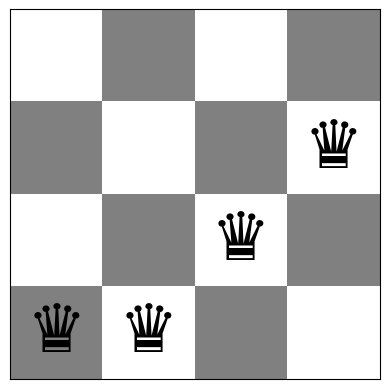

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [2]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


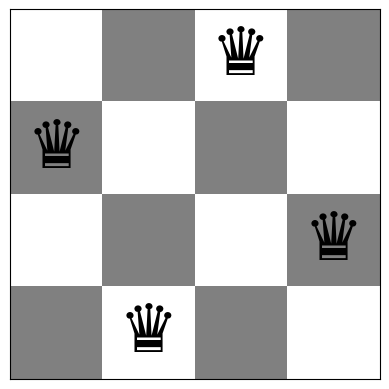

In [3]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [20 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

In [ ]:
# Code and description go here
# Implement steepest-ascent hill climbing for n-queens
import random, copy, math, time
from typing import List, Tuple

def conflicts_count(state: List[int]) -> int:
    """Return number of attacking pairs of queens (conflicts). 
    state[col]=row"""
    n = len(state)
    row_counts = {}
    diag1 = {}  # r - c
    diag2 = {}  # r + c
    for c, r in enumerate(state):
        row_counts[r] = row_counts.get(r, 0) + 1
        d1 = r - c
        d2 = r + c
        diag1[d1] = diag1.get(d1, 0) + 1
        diag2[d2] = diag2.get(d2, 0) + 1
    conflicts = 0
    for cnt in row_counts.values():
        if cnt > 1:
            conflicts += cnt * (cnt - 1) // 2
    for cnt in diag1.values():
        if cnt > 1:
            conflicts += cnt * (cnt - 1) // 2
    for cnt in diag2.values():
        if cnt > 1:
            conflicts += cnt * (cnt - 1) // 2
    return conflicts

def objective_non_attacking_pairs(state: List[int]) -> int:
    """Objective: number of non-attacking pairs (higher is better)."""
    n = len(state)
    total_pairs = n * (n - 1) // 2
    conflicts = conflicts_count(state)
    return total_pairs - conflicts

def steepest_ascent_hill_climbing(n:int, init_state:List[int]=None, max_iters:int=1000, random_restart:bool=False, verbose:bool=False) -> dict:
    """Perform steepest-ascent hill climbing.
    Local moves: for each column, move queen to any other row in same column.
    At each iteration evaluate objective for ALL local moves and pick the best.
    If no improving move exists -> local optimum.
    Returns dict with final state, objective history, iterations, time, success flag (zero-conflict).
    """
    start_time = time.time()
    if init_state is None:
        state = [random.randrange(n) for _ in range(n)]
    else:
        state = init_state.copy()
    history = [objective_non_attacking_pairs(state)]
    iters = 0
    while iters < max_iters:
        iters += 1
        current_obj = objective_non_attacking_pairs(state)
        best_obj = current_obj
        best_move = None  # (col, new_row)
        # Evaluate all local moves
        for col in range(n):
            orig_row = state[col]
            for new_row in range(n):
                if new_row == orig_row:
                    continue
                state[col] = new_row
                obj = objective_non_attacking_pairs(state)
                if obj > best_obj:
                    best_obj = obj
                    best_move = (col, new_row)
            state[col] = orig_row  # restore
        # If no improving move, reached local optimum
        if best_move is None:
            break
        # Apply best move (steepest)
        col, new_row = best_move
        state[col] = new_row
        history.append(best_obj)
        if verbose:
            print(f"Iter {iters}: applied move col={col} -> row={new_row}, obj={best_obj}")
        # success check
        if conflicts_count(state) == 0:
            break
    elapsed = time.time() - start_time
    return {
        "final_state": state,
        "objective_history": history,
        "iterations": iters,
        "time": elapsed,
        "conflicts": conflicts_count(state),
        "success": conflicts_count(state) == 0
    }

# Quick demo for n=8, run a few restarts to show behavior
def demo_runs(n=8, runs=5, max_iters=1000):
    results = []
    for i in range(runs):
        res = steepest_ascent_hill_climbing(n, max_iters=max_iters)
        results.append(res)
    # summarize
    for i,res in enumerate(results):
        print(f"Run {i+1}: iterations={res['iterations']}, conflicts={res['conflicts']}, success={res['success']}, time={res['time']:.4f}s, final_obj={res['objective_history'][-1]}")
    return results

# Run demo
demo_results = demo_runs(n=8, runs=6)


Run 1: iterations=5, conflicts=1, success=False, time=0.0020s, final_obj=27
Run 2: iterations=3, conflicts=0, success=True, time=0.0000s, final_obj=28
Run 3: iterations=4, conflicts=1, success=False, time=0.0015s, final_obj=27
Run 4: iterations=5, conflicts=2, success=False, time=0.0010s, final_obj=26
Run 5: iterations=5, conflicts=1, success=False, time=0.0010s, final_obj=27
Run 6: iterations=2, conflicts=3, success=False, time=0.0000s, final_obj=25


## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [6]:
# Code and description go here
import random, time
from typing import List

def stochastic_hill_climbing(n:int, init_state:List[int]=None, max_iters:int=1000, verbose:bool=False) -> dict:
    """Stochastic Hill Climbing: chọn ngẫu nhiên từ các uphill moves."""
    start_time = time.time()
    if init_state is None:
        state = [random.randrange(n) for _ in range(n)]
    else:
        state = init_state.copy()
    history = [objective_non_attacking_pairs(state)]
    iters = 0
    
    while iters < max_iters:
        iters += 1
        current_obj = objective_non_attacking_pairs(state)
        improving_moves = []
        # tìm tất cả uphill moves
        for col in range(n):
            orig_row = state[col]
            for new_row in range(n):
                if new_row == orig_row:
                    continue
                state[col] = new_row
                obj = objective_non_attacking_pairs(state)
                if obj > current_obj:
                    improving_moves.append((col, new_row, obj))
            state[col] = orig_row
        
        # nếu không có move nào cải thiện → local optimum
        if not improving_moves:
            break
        
        # chọn ngẫu nhiên 1 move trong số các uphill moves
        col, new_row, new_obj = random.choice(improving_moves)
        state[col] = new_row
        history.append(new_obj)
        
        if verbose:
            print(f"Iter {iters}: move col={col} -> row={new_row}, obj={new_obj}")
        
        # check thành công (không còn conflict)
        if conflicts_count(state) == 0:
            break
    
    elapsed = time.time() - start_time
    return {
        "final_state": state,
        "objective_history": history,
        "iterations": iters,
        "time": elapsed,
        "conflicts": conflicts_count(state),
        "success": conflicts_count(state) == 0
    }

# Demo vài lần cho N=8
def demo_stochastic(n=8, runs=6):
    for i in range(runs):
        res = stochastic_hill_climbing(n, max_iters=1000)
        print(f"Run {i+1}: iters={res['iterations']}, conflicts={res['conflicts']}, success={res['success']}, final_obj={res['objective_history'][-1]}")

demo_results = demo_stochastic(n=8, runs=6)

Run 1: iters=5, conflicts=0, success=True, final_obj=28
Run 2: iters=7, conflicts=1, success=False, final_obj=27
Run 3: iters=7, conflicts=2, success=False, final_obj=26
Run 4: iters=5, conflicts=1, success=False, final_obj=27
Run 5: iters=5, conflicts=1, success=False, final_obj=27
Run 6: iters=6, conflicts=1, success=False, final_obj=27


## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [15]:
# Code and description go here
def first_choice_hill_climbing(n:int, init_state:List[int]=None, max_iters:int=1000, patience:int=100, verbose:bool=False) -> dict:
    """
    First-choice hill climbing (Stochastic Hill Climbing 2).
    - patience: số lần thử tối đa liên tiếp không cải thiện trước khi dừng.
    """
    start_time = time.time()
    if init_state is None:
        state = [random.randrange(n) for _ in range(n)]
    else:
        state = init_state.copy()
    
    current_obj = objective_non_attacking_pairs(state)
    history = [current_obj]
    iters = 0
    no_improve = 0   # đếm số lần thử không cải thiện
    
    while iters < max_iters and no_improve < patience:
        iters += 1
        col = random.randrange(n)
        new_row = random.randrange(n)
        while new_row == state[col]:
            new_row = random.randrange(n)
        
        # thử move
        orig_row = state[col]
        state[col] = new_row
        new_obj = objective_non_attacking_pairs(state)
        
        if new_obj > current_obj:   # accept nếu cải thiện
            current_obj = new_obj
            history.append(new_obj)
            no_improve = 0
            if verbose:
                print(f"Iter {iters}: accepted move col={col}->{new_row}, obj={new_obj}")
        else:
            # revert
            state[col] = orig_row
            no_improve += 1
        
        # thành công nếu không còn xung đột
        if conflicts_count(state) == 0:
            break
    
    elapsed = time.time() - start_time
    return {
        "final_state": state,
        "objective_history": history,
        "iterations": iters,
        "time": elapsed,
        "conflicts": conflicts_count(state),
        "success": conflicts_count(state) == 0
    }

# Demo
def demo_first_choice(n=8, runs=6):
    for i in range(runs):
        res = first_choice_hill_climbing(n, max_iters=2000, patience=200)
        print(f"Run {i+1}: iters={res['iterations']}, conflicts={res['conflicts']}, success={res['success']}, final_obj={res['objective_history'][-1]}")

demo_run = demo_first_choice(n=8,runs=6)

Run 1: iters=232, conflicts=2, success=False, final_obj=26
Run 2: iters=140, conflicts=0, success=True, final_obj=28
Run 3: iters=250, conflicts=2, success=False, final_obj=26
Run 4: iters=238, conflicts=1, success=False, final_obj=27
Run 5: iters=248, conflicts=2, success=False, final_obj=26
Run 6: iters=201, conflicts=0, success=True, final_obj=28


## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

In [157]:
# Code and description go here
def hill_climbing_with_restarts(algorithm_func, n:int, restarts:int=100, max_iters:int=1000, patience:int=200) -> dict:
    """
    Thực hiện Random Restarts cho một thuật toán hill climbing bất kỳ.
    
    algorithm_func: hàm hill climbing (steepest_ascent_hill_climbing / stochastic_hill_climbing / first_choice_hill_climbing)
    n: số quân hậu
    restarts: số lần restart
    max_iters, patience: tham số truyền cho thuật toán con
    
    Trả về: best result trong các lần chạy
    """
    best_result = None
    successes = 0
    for i in range(restarts):
        if algorithm_func.__name__ == "first_choice_hill_climbing":
            res = algorithm_func(n, max_iters=max_iters, patience=patience)
        else:
            res = algorithm_func(n, max_iters=max_iters)
        
        if res["success"]:
            successes += 1
        
        if best_result is None or res["objective_history"][-1] > best_result["objective_history"][-1]:
            best_result = res
    
    best_result["successes"] = successes
    best_result["restarts"] = restarts
    return best_result

# Steepest-ascent with restarts
best1 = hill_climbing_with_restarts(steepest_ascent_hill_climbing, n=8, restarts=100)
print("Steepest-ascent + restarts:", best1["successes"], "/", best1["restarts"], "successes")

# Stochastic HC1 with restarts
best2 = hill_climbing_with_restarts(stochastic_hill_climbing, n=8, restarts=100)
print("Stochastic HC1 + restarts:", best2["successes"], "/", best2["restarts"], "successes")

# First-choice HC (Stochastic HC2) with restarts
best3 = hill_climbing_with_restarts(first_choice_hill_climbing, n=8, restarts=100)
print("First-choice HC + restarts:", best3["successes"], "/", best3["restarts"], "successes")


Steepest-ascent + restarts: 23 / 100 successes
Stochastic HC1 + restarts: 15 / 100 successes
First-choice HC + restarts: 13 / 100 successes


## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Create a visualization of the search process (a line chart of how the number if conflict changes as the algorithm progrsses).
3. Use this visualization for experiments with different choices for the annealing schedule and discuss what you have learned.

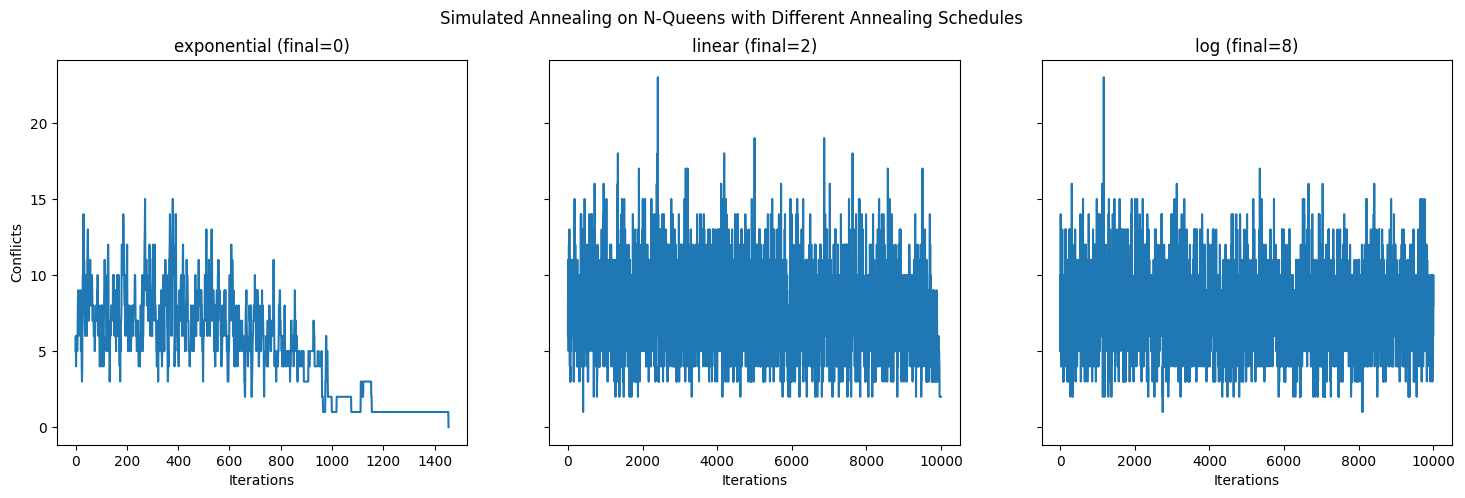

In [161]:
# Code and description go here
import random
import math
import matplotlib.pyplot as plt

# Objective: number of conflicts
def conflicts(board):
    n = len(board)
    conflict_count = 0
    for i in range(n):
        for j in range(i+1, n):
            if board[i] == board[j] or abs(board[i]-board[j]) == abs(i-j):
                conflict_count += 1
    return conflict_count

# Generate a neighbor by moving one queen
def random_neighbor(board):
    n = len(board)
    neighbor = board.copy()
    col = random.randint(0, n-1)
    new_row = random.randint(0, n-1)
    while new_row == neighbor[col]:
        new_row = random.randint(0, n-1)
    neighbor[col] = new_row
    return neighbor

# Simulated Annealing
def simulated_annealing(n, T0=100, alpha=0.99, max_steps=10000, schedule="exponential"):
    # initial state: random board
    board = [random.randint(0, n-1) for _ in range(n)]
    current_conflicts = conflicts(board)
    T = T0
    history = [current_conflicts]

    for step in range(1, max_steps+1):
        if current_conflicts == 0:
            break  # solution found

        # choose neighbor
        neighbor = random_neighbor(board)
        neighbor_conflicts = conflicts(neighbor)
        deltaE = neighbor_conflicts - current_conflicts

        # acceptance condition
        if deltaE < 0:
            board, current_conflicts = neighbor, neighbor_conflicts
        else:
            prob = math.exp(-deltaE / T) if T > 0 else 0
            if random.random() < prob:
                board, current_conflicts = neighbor, neighbor_conflicts

        history.append(current_conflicts)

        # update temperature
        if schedule == "exponential":
            T = T0 * (alpha ** step)
        elif schedule == "linear":
            T = max(0.01, T0 - step*0.01)
        elif schedule == "log":
            T = T0 / math.log(step+2)
        else:
            raise ValueError("Unknown schedule")

    return board, current_conflicts, history

# Run experiments with different schedules
n = 8  # size of board
schedules = ["exponential", "linear", "log"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, sched in enumerate(schedules):
    _, conf, hist = simulated_annealing(n, T0=100, alpha=0.995, schedule=sched)
    axes[i].plot(hist, color="tab:blue")
    axes[i].set_title(f"{sched} (final={conf})")
    axes[i].set_xlabel("Iterations")
    if i == 0:
        axes[i].set_ylabel("Conflicts")

plt.suptitle("Simulated Annealing on N-Queens with Different Annealing Schedules")
plt.show()



## Task 6: Algorithm Behavior Analysis [20 Points]

### Comparison
Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                   |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                   |   |

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

Add the used code here:

In [162]:
# Code
import random
import time
import math
import numpy as np

# ---------- Utility functions ----------
def random_board(n):
    """Tạo một board ngẫu nhiên"""
    return [random.randint(0, n-1) for _ in range(n)]

def compute_conflicts(board):
    """Tính số conflicts trên board"""
    n = len(board)
    conflicts = 0
    for i in range(n):
        for j in range(i+1, n):
            if board[i] == board[j] or abs(board[i]-board[j]) == abs(i-j):
                conflicts += 1
    return conflicts

def get_neighbors(board):
    """Sinh neighbors bằng cách đổi vị trí 1 quân hậu"""
    n = len(board)
    neighbors = []
    for col in range(n):
        for row in range(n):
            if row != board[col]:
                new_board = board.copy()
                new_board[col] = row
                neighbors.append(new_board)
    return neighbors

# ---------- Algorithms ----------
def steepest_ascent_hc(n, max_restarts=1):
    best_board = None
    best_conflicts = float("inf")

    for _ in range(max_restarts):
        board = random_board(n)
        while True:
            neighbors = get_neighbors(board)
            if not neighbors:
                break
            next_board = min(neighbors, key=compute_conflicts)
            if compute_conflicts(next_board) < compute_conflicts(board):
                board = next_board
            else:
                break
        if compute_conflicts(board) < best_conflicts:
            best_board = board
            best_conflicts = compute_conflicts(board)

    return best_board, best_conflicts

def stochastic_hc1(n, max_restarts=1):
    best_board = None
    best_conflicts = float("inf")

    for _ in range(max_restarts):
        board = random_board(n)
        while True:
            neighbors = get_neighbors(board)
            better_neighbors = [nb for nb in neighbors if compute_conflicts(nb) < compute_conflicts(board)]
            if not better_neighbors:
                break
            board = random.choice(better_neighbors)
        if compute_conflicts(board) < best_conflicts:
            best_board = board
            best_conflicts = compute_conflicts(board)

    return best_board, best_conflicts

def stochastic_hc2_first_choice(n, max_restarts=1, max_tries=200):
    best_board = None
    best_conflicts = float("inf")

    for _ in range(max_restarts):
        board = random_board(n)
        tries = 0
        while tries < max_tries:
            col = random.randint(0, n-1)
            row = random.randint(0, n-1)
            if row != board[col]:
                new_board = board.copy()
                new_board[col] = row
                if compute_conflicts(new_board) < compute_conflicts(board):
                    board = new_board
                    tries = 0
                else:
                    tries += 1
        if compute_conflicts(board) < best_conflicts:
            best_board = board
            best_conflicts = compute_conflicts(board)

    return best_board, best_conflicts

def simulated_annealing(n, max_steps=1000, T_start=1.0, T_end=1e-3, alpha=0.99):
    board = random_board(n)
    current_conflicts = compute_conflicts(board)
    T = T_start

    for step in range(max_steps):
        if T < T_end or current_conflicts == 0:
            break
        col = random.randint(0, n-1)
        row = random.randint(0, n-1)
        if row != board[col]:
            new_board = board.copy()
            new_board[col] = row
            new_conflicts = compute_conflicts(new_board)
            delta = new_conflicts - current_conflicts
            if delta < 0 or random.random() < math.exp(-delta / T):
                board, current_conflicts = new_board, new_conflicts
        T *= alpha

    return board, current_conflicts

# ---------- Experiment Runner ----------
def run_experiment(n, algorithm, max_restarts=100, runs=100):
    runtimes = []
    conflicts = []
    successes = 0

    for _ in range(runs):
        start = time.time()
        if algorithm == "steepest":
            board, conf = steepest_ascent_hc(n, max_restarts)
        elif algorithm == "stochastic1":
            board, conf = stochastic_hc1(n, max_restarts)
        elif algorithm == "stochastic2":
            board, conf = stochastic_hc2_first_choice(n, max_restarts)
        elif algorithm == "annealing":
            board, conf = simulated_annealing(n)
        else:
            raise ValueError("Unknown algorithm")
        end = time.time()

        runtimes.append(end - start)
        conflicts.append(conf)
        if conf == 0:
            successes += 1

    return {
        "avg_runtime": np.mean(runtimes),
        "avg_conflicts": np.mean(conflicts),
        "success_rate": successes / runs * 100
    }

# ---------- Run all experiments ----------
board_sizes = [4, 8]
algorithms = ["steepest", "stochastic1", "stochastic2", "annealing"]
results = []

for n in board_sizes:
    for algo in algorithms:
        res = run_experiment(n, algo, max_restarts=100, runs=100)
        results.append((algo, n, res))

# ---------- Print results ----------
print("| Algorithm           | Board size | Avg. Run time | Avg. Conflicts | % Optimal |")
print("| ------------------- | ---------- | ------------- | -------------- | --------- |")
for algo, n, res in results:
    name = {
        "steepest": "Steepest asc. HC",
        "stochastic1": "Stochastic HC1",
        "stochastic2": "Stochastic HC2",
        "annealing": "Simulated Annealing"
    }[algo]
    print(f"| {name:<18} | {n:<10} | {res['avg_runtime']:.5f}    | {res['avg_conflicts']:.2f}          | {res['success_rate']:.1f}% |")


| Algorithm           | Board size | Avg. Run time | Avg. Conflicts | % Optimal |
| ------------------- | ---------- | ------------- | -------------- | --------- |
| Steepest asc. HC   | 4          | 0.00425    | 0.00          | 100.0% |
| Stochastic HC1     | 4          | 0.00730    | 0.00          | 100.0% |
| Stochastic HC2     | 4          | 0.06213    | 0.00          | 100.0% |
| Simulated Annealing | 4          | 0.00011    | 0.00          | 100.0% |
| Steepest asc. HC   | 8          | 0.07936    | 0.00          | 100.0% |
| Stochastic HC1     | 8          | 0.22008    | 0.00          | 100.0% |
| Stochastic HC2     | 8          | 0.20491    | 0.00          | 100.0% |
| Simulated Annealing | 8          | 0.00172    | 0.34          | 66.0% |


### Algorithm Convergence

For each algorithm implemented, describe the typical convergence pattern (fast initial improvement vs. steady progress).
Include a plot showing the objective function value over iterations for one representative run of each algorithm on the 8-queens problem.
Explain which algorithms exhibit plateaus or getting stuck in local optima most frequently.

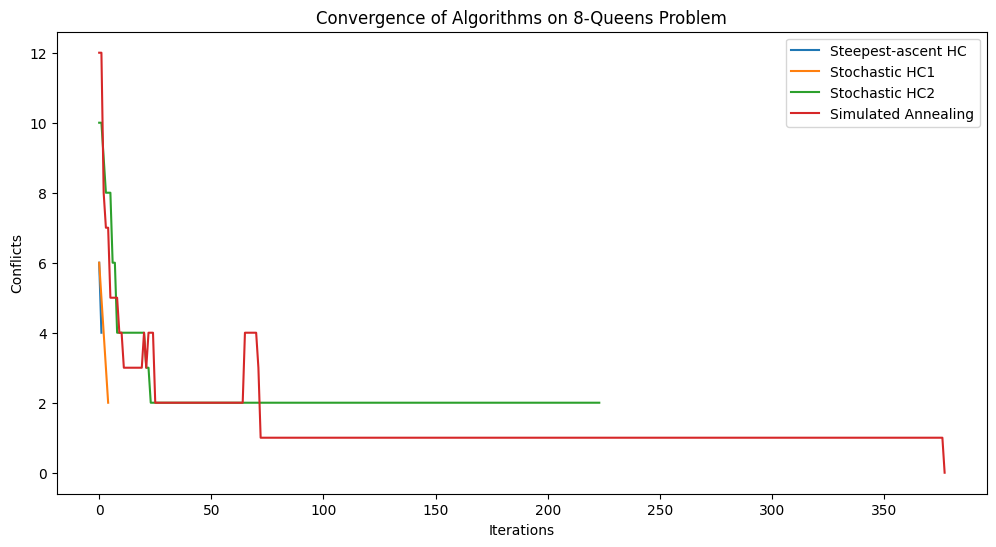

In [ ]:
# Code and description go here
import random
import math
import matplotlib.pyplot as plt

# --- Utility functions ---

def random_board(n):
    """Khởi tạo bàn cờ ngẫu nhiên (list vị trí của queen trong từng cột)."""
    return [random.randint(0, n-1) for _ in range(n)]

def compute_conflicts(board):
    """Tính số lượng cặp quân hậu tấn công nhau."""
    conflicts = 0
    n = len(board)
    for i in range(n):
        for j in range(i+1, n):
            if board[i] == board[j] or abs(board[i]-board[j]) == abs(i-j):
                conflicts += 1
    return conflicts

def get_neighbors(board):
    """Sinh ra tất cả neighbors bằng cách di chuyển một quân hậu trong cùng cột."""
    neighbors = []
    n = len(board)
    for col in range(n):
        for row in range(n):
            if board[col] != row:
                new_board = board.copy()
                new_board[col] = row
                neighbors.append(new_board)
    return neighbors

# --- Algorithms with logging ---

def steepest_ascent_hc_log(n):
    board = random_board(n)
    conflicts_log = [compute_conflicts(board)]

    while True:
        neighbors = get_neighbors(board)
        if not neighbors:
            break
        next_board = min(neighbors, key=compute_conflicts)
        if compute_conflicts(next_board) < compute_conflicts(board):
            board = next_board
            conflicts_log.append(compute_conflicts(board))
        else:
            break
    return conflicts_log

def stochastic_hc1_log(n):
    board = random_board(n)
    conflicts_log = [compute_conflicts(board)]

    while True:
        neighbors = get_neighbors(board)
        better_neighbors = [nb for nb in neighbors if compute_conflicts(nb) < compute_conflicts(board)]
        if not better_neighbors:
            break
        board = random.choice(better_neighbors)
        conflicts_log.append(compute_conflicts(board))
    return conflicts_log

def stochastic_hc2_log(n, max_tries=200):
    board = random_board(n)
    conflicts_log = [compute_conflicts(board)]
    tries = 0

    while tries < max_tries:
        col = random.randint(0, n-1)
        row = random.randint(0, n-1)
        if row != board[col]:
            new_board = board.copy()
            new_board[col] = row
            if compute_conflicts(new_board) < compute_conflicts(board):
                board = new_board
                tries = 0
            else:
                tries += 1
            conflicts_log.append(compute_conflicts(board))
    return conflicts_log

def simulated_annealing_log(n, max_steps=1000, T_start=1.0, T_end=1e-3, alpha=0.99):
    board = random_board(n)
    current_conflicts = compute_conflicts(board)
    conflicts_log = [current_conflicts]
    T = T_start

    for step in range(max_steps):
        if T < T_end or current_conflicts == 0:
            break
        col = random.randint(0, n-1)
        row = random.randint(0, n-1)
        if row != board[col]:
            new_board = board.copy()
            new_board[col] = row
            new_conflicts = compute_conflicts(new_board)
            delta = new_conflicts - current_conflicts
            if delta < 0 or random.random() < math.exp(-delta / T):
                board, current_conflicts = new_board, new_conflicts
        conflicts_log.append(current_conflicts)
        T *= alpha

    return conflicts_log

# --- Run representative runs ---
logs = {
    "Steepest-ascent HC": steepest_ascent_hc_log(8),
    "Stochastic HC1": stochastic_hc1_log(8),
    "Stochastic HC2": stochastic_hc2_log(8),
    "Simulated Annealing": simulated_annealing_log(8)
}

# --- Plot ---
plt.figure(figsize=(12, 6))
for algo, log in logs.items():
    plt.plot(log, label=algo)
plt.xlabel("Iterations")
plt.ylabel("Conflicts")
plt.title("Convergence of Algorithms on 8-Queens Problem")
plt.legend()
plt.show()


# 2. Phần mô tả mẫu
# Steepest-ascent Hill Climbing: Giảm nhanh số conflicts ban đầu, nhưng thường nhanh chóng chững lại (plateau) và dừng khi đạt local optimum.
# Stochastic HC1: Tiến trình cải thiện ngẫu nhiên hơn, thường hội tụ chậm hơn nhưng có cơ hội thoát plateau nhỏ.
# Stochastic HC2 (First-choice): Thay đổi nhỏ, mỗi lần thử một neighbor → cải thiện chậm, dễ mắc kẹt trong local optimum nếu không may.
# Simulated Annealing: Cho phép chấp nhận cả bước “xấu” (downhill moves), do đó có thể vượt qua local optimum. Hội tụ không ổn định, nhưng có khả năng tìm giải tối ưu sau nhiều bước.

# 3. Phân tích plateau / local optima
# Plateau (dừng mà không về 0 conflicts) thường gặp nhiều ở Steepest HC và Stochastic HC2.
# Stochastic HC1 ít hơn, nhưng vẫn có thể mắc kẹt.
# Simulated Annealing ít khi bị plateau vì có cơ chế “thoát kẹt”, nhưng đôi khi kết thúc với nghiệm chưa tối ưu.

### Problem Size Scalability

Create a log-log plot showing how runtime scales with board size ($n=4, 8, 12, 16, 20$) for at least two algorithms.
Estimate the empirical time complexity (Big O) for each algorithm based on your results.
Identify which algorithm scales best for large problem sizes and explain why.

Running experiments (this may take a short while)...
Steepest-ascent HC     n=4  avg_time=0.000035s over 30 runs
Steepest-ascent HC     n=8  avg_time=0.000722s over 30 runs
Steepest-ascent HC     n=12 avg_time=0.005606s over 30 runs
Steepest-ascent HC     n=16 avg_time=0.022668s over 30 runs
Steepest-ascent HC     n=20 avg_time=0.068532s over 30 runs
Simulated Annealing    n=4  avg_time=0.000110s over 30 runs
Simulated Annealing    n=8  avg_time=0.002748s over 30 runs
Simulated Annealing    n=12 avg_time=0.016754s over 30 runs
Simulated Annealing    n=16 avg_time=0.039090s over 30 runs
Simulated Annealing    n=20 avg_time=0.061040s over 30 runs


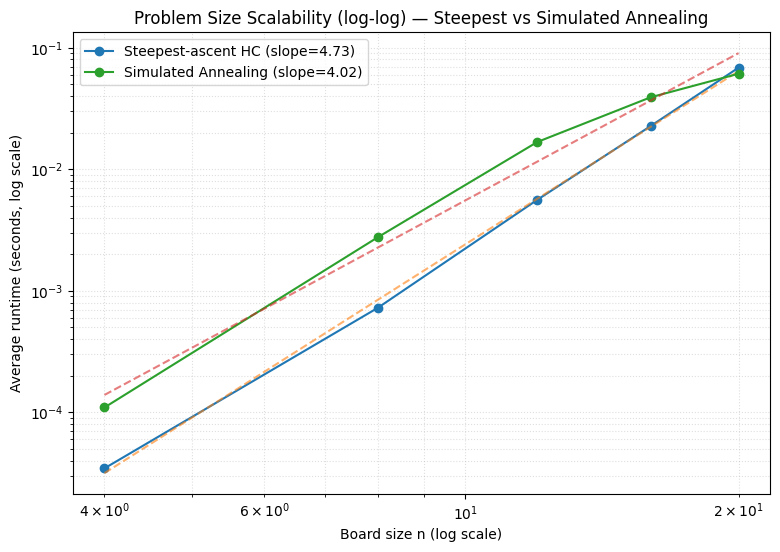


Estimated empirical complexity (from log-log slope):
- Steepest-ascent HC    : slope=4.732 -> approx O(n^4.73)
- Simulated Annealing   : slope=4.024 -> approx O(n^4.02)


In [4]:
# Code and description go here
# Full self-contained code for "Problem Size Scalability"
# Defines algorithms, measures runtime for n = [4,8,12,16,20],
# plots log-log runtime and fits slope (empirical exponent).

import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Utilities
# -----------------------
def random_board(n):
    return [random.randint(0, n-1) for _ in range(n)]

def compute_conflicts(board):
    n = len(board)
    conf = 0
    for i in range(n):
        for j in range(i+1, n):
            if board[i] == board[j] or abs(board[i]-board[j]) == abs(i-j):
                conf += 1
    return conf

def get_neighbors(board):
    n = len(board)
    neighs = []
    for col in range(n):
        for row in range(n):
            if row != board[col]:
                nb = board.copy()
                nb[col] = row
                neighs.append(nb)
    return neighs

# -----------------------
# Algorithms (return final board)
# -----------------------
def steepest_ascent_hc(n, max_iters=1000):
    board = random_board(n)
    for it in range(max_iters):
        curr_conf = compute_conflicts(board)
        if curr_conf == 0:
            break
        best_conf = curr_conf
        best_board = None
        # evaluate all local moves
        for col in range(n):
            orig_row = board[col]
            for row in range(n):
                if row == orig_row:
                    continue
                board[col] = row
                conf = compute_conflicts(board)
                if conf < best_conf:
                    best_conf = conf
                    best_board = board.copy()
            board[col] = orig_row
        if best_board is None:
            # no improving move -> local optimum
            break
        board = best_board
    return board

def simulated_annealing(n, max_steps=5000, T0=1.0, alpha=0.995):
    board = random_board(n)
    curr_conf = compute_conflicts(board)
    T = T0
    for step in range(max_steps):
        if curr_conf == 0:
            break
        # random neighbor (move one random queen)
        col = random.randrange(n)
        row = random.randrange(n)
        while row == board[col]:
            row = random.randrange(n)
        candidate = board.copy()
        candidate[col] = row
        cand_conf = compute_conflicts(candidate)
        dE = cand_conf - curr_conf
        # accept rule
        if dE < 0 or random.random() < math.exp(-dE / max(T, 1e-12)):
            board = candidate
            curr_conf = cand_conf
        T *= alpha
    return board

# -----------------------
# Measurement helper
# -----------------------
def measure_runtime(func, n, runs=30):
    durations = []
    # keep functions pure in measurement: use same signature func(n)
    for _ in range(runs):
        t0 = time.perf_counter()
        func(n)
        t1 = time.perf_counter()
        durations.append(t1 - t0)
    return float(np.mean(durations)), durations

# -----------------------
# Experiment: run for sizes and two algorithms
# -----------------------
board_sizes = [4, 8, 12, 16, 20]
runs_per_setting = 30

algorithms = {
    "Steepest-ascent HC": steepest_ascent_hc,
    "Simulated Annealing": simulated_annealing
}

results = {name: [] for name in algorithms}

print("Running experiments (this may take a short while)...")
for name, func in algorithms.items():
    for n in board_sizes:
        avg_t, all_ts = measure_runtime(func, n, runs=runs_per_setting)
        results[name].append(avg_t)
        print(f"{name:22s} n={n:<2d} avg_time={avg_t:.6f}s over {runs_per_setting} runs")

# -----------------------
# Fit slope on log-log and plot
# -----------------------
plt.figure(figsize=(9,6))
x = np.array(board_sizes)
logx = np.log(x)

for name, times in results.items():
    y = np.array(times)
    logy = np.log(y)
    # linear fit in log-log: logy = a + b*logx  => slope = b
    slope, intercept = np.polyfit(logx, logy, 1)
    # plot raw points
    plt.plot(x, y, marker='o', label=f"{name} (slope={slope:.2f})")
    # plot fitted power-law line for visualization
    fit_y = np.exp(intercept) * x**slope
    plt.plot(x, fit_y, linestyle='--', alpha=0.6)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Board size n (log scale)")
plt.ylabel("Average runtime (seconds, log scale)")
plt.title("Problem Size Scalability (log-log) — Steepest vs Simulated Annealing")
plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

# -----------------------
# Print estimated complexities
# -----------------------
print("\nEstimated empirical complexity (from log-log slope):")
for name, times in results.items():
    slope, intercept = np.polyfit(logx, np.log(times), 1)
    approx = f"O(n^{slope:.2f})"
    print(f"- {name:22s}: slope={slope:.3f} -> approx {approx}")



## Advanced task: Exploring other Local Moves Operators

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### Move Operator Implementation 

Implement the following local move operators:

* Single-step move: Move one queen only one square up or down at a time
* Column swap: Exchange the positions of queens in two randomly selected columns
* Dual-queen move: Select two queens and move both simultaneously
* Adaptive move: Design your own operator that adapts which local move it uses based on the current state (e.g., focuses on queens with most conflicts or randomly chooses one of the moves above)

### Experimental Analysis

Using the 8-Queens and 12-Queens problems: Run your Stochastic Hill Climbing 2 implementation with each move operator 100 times
For each operator, create a visualization showing:

* Average solution quality over iterations
* Distribution of final solution qualities
* Average time to solution for successful runs

### Discussion

Describe what you have learned from the experiments. Which operator works best for which situation and why?

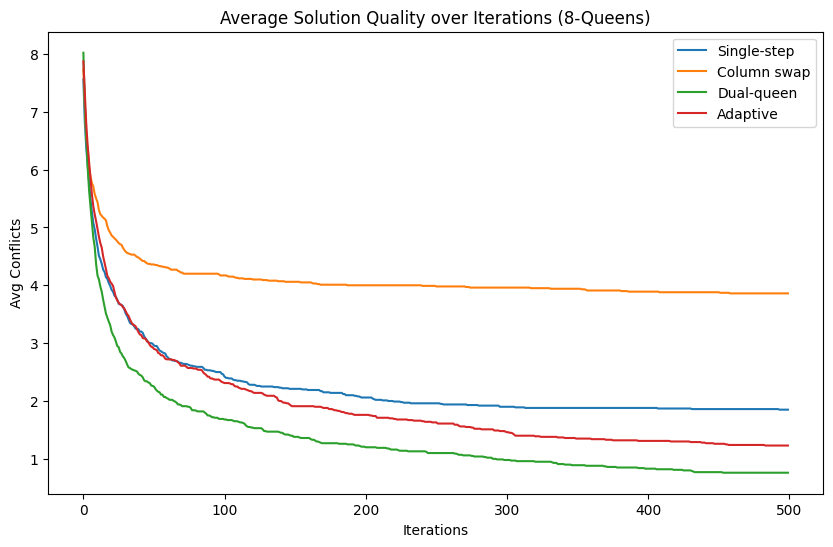

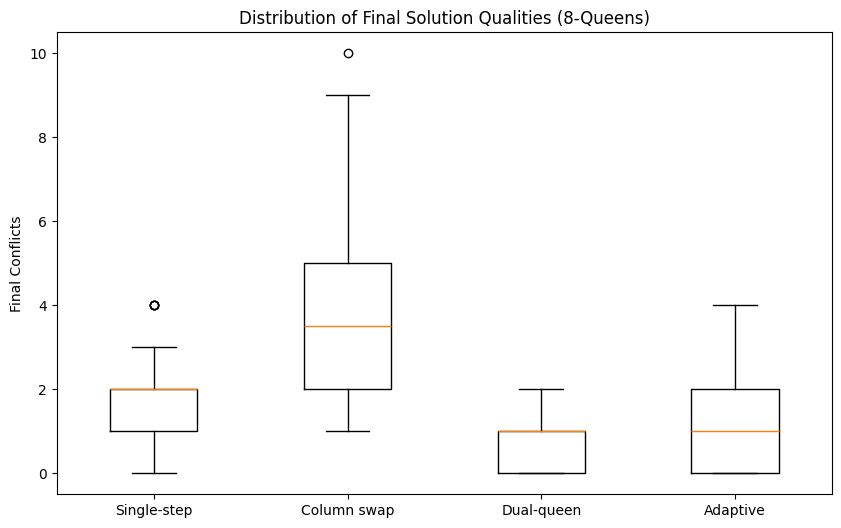

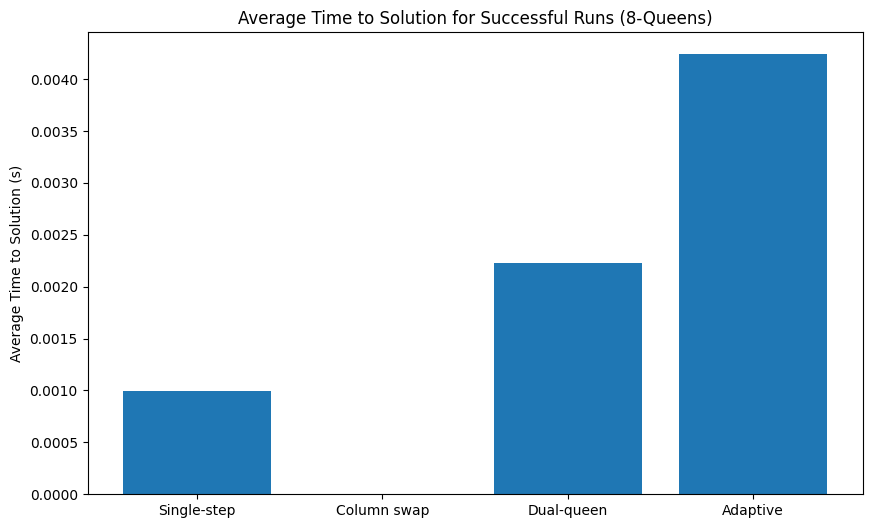

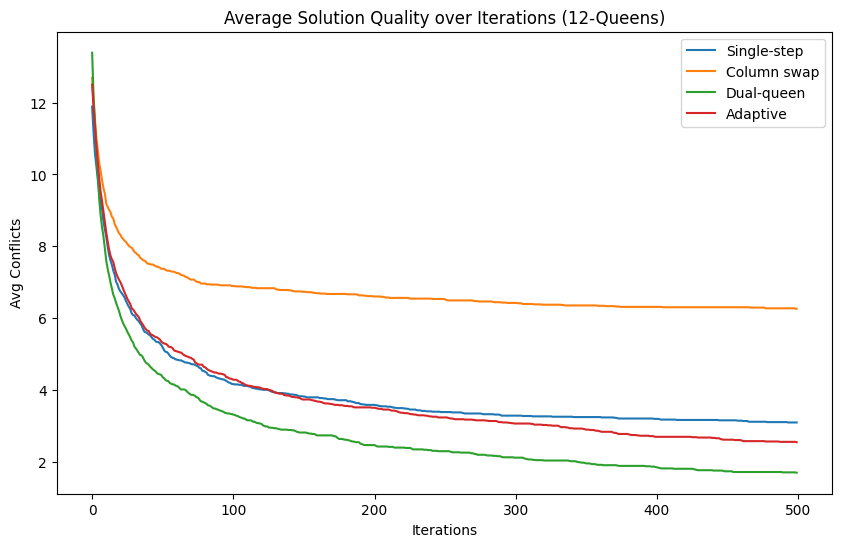

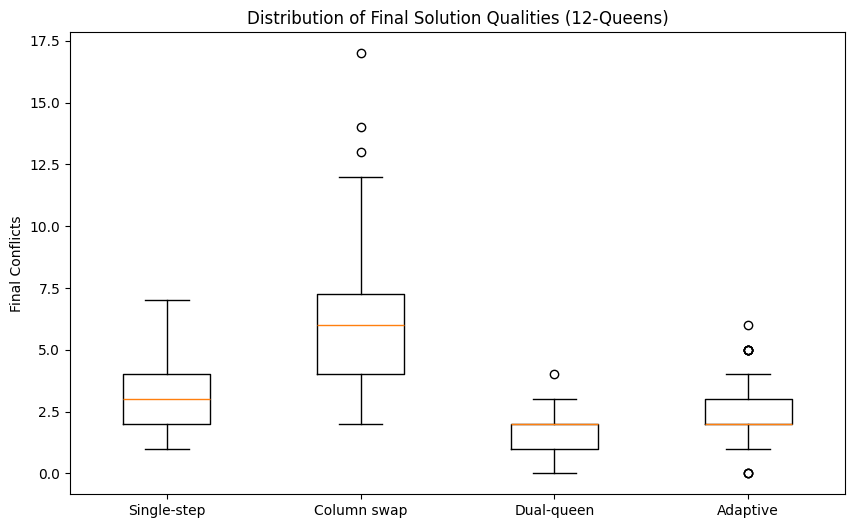

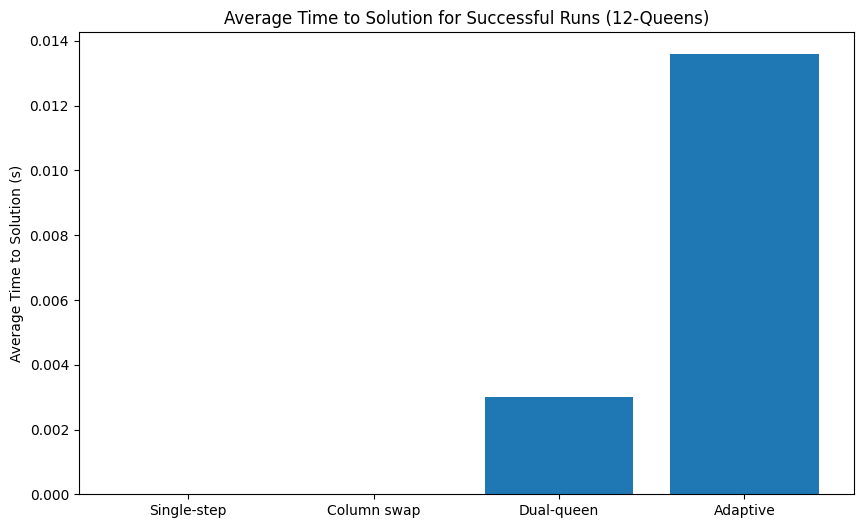

In [9]:
# Code and description go here
# 1. Các Move Operators cần cài đặt
# Mở rộng cho Stochastic Hill Climbing 2 (HC2) nhưng thay đổi cách sinh neighbor:
#     Single-step move: Chọn một queen và di chuyển lên hoặc xuống 1 ô.
#     Column swap: Hoán đổi vị trí hai cột (hai queens).
#     Dual-queen move: Chọn 2 queens và di chuyển cả 2 đến hàng mới.
#     Adaptive move: Tự chọn move, ví dụ:
#             Nếu số xung đột cao → dùng dual-queen move hoặc swap.
#             Nếu số xung đột ít → dùng single-step để tinh chỉnh.
#             Thỉnh thoảng chọn random để tránh kẹt local optima.

import random
import numpy as np
import time
import matplotlib.pyplot as plt

# --------- Utility Functions ---------
def random_board(N):
    """Tạo board ngẫu nhiên với mỗi cột có 1 quân hậu"""
    return [random.randint(0, N-1) for _ in range(N)]

def compute_conflicts(board):
    """Đếm số cặp quân hậu tấn công nhau"""
    N = len(board)
    conflicts = 0
    for i in range(N):
        for j in range(i+1, N):
            if board[i] == board[j] or abs(board[i]-board[j]) == abs(i-j):
                conflicts += 1
    return conflicts

# --------- Move Operators ---------
def single_step_move(board):
    N = len(board)
    new_board = board[:]
    col = random.randint(0, N-1)
    direction = random.choice([-1, 1])
    new_row = new_board[col] + direction
    if 0 <= new_row < N:
        new_board[col] = new_row
    return new_board

def column_swap(board):
    N = len(board)
    new_board = board[:]
    c1, c2 = random.sample(range(N), 2)
    new_board[c1], new_board[c2] = new_board[c2], new_board[c1]
    return new_board

def dual_queen_move(board):
    N = len(board)
    new_board = board[:]
    cols = random.sample(range(N), 2)
    for c in cols:
        new_board[c] = random.randint(0, N-1)
    return new_board

def adaptive_move(board):
    """Chọn operator dựa vào xung đột"""
    N = len(board)
    # chọn cột có nhiều xung đột nhất
    conflicts = []
    for col in range(N):
        cnt = 0
        for j in range(N):
            if j != col and (board[col] == board[j] or abs(board[col]-board[j]) == abs(col-j)):
                cnt += 1
        conflicts.append(cnt)
    worst_col = np.argmax(conflicts)
    # nếu xung đột cao thì dịch chuyển nhỏ, còn không thì swap hoặc dual
    r = random.random()
    if conflicts[worst_col] > 1:
        return single_step_move(board)
    elif r < 0.5:
        return column_swap(board)
    else:
        return dual_queen_move(board)

# --------- Stochastic Hill Climbing 2 ---------
def stochastic_hill_climbing_2(N, move_operator, max_iter=500):
    board = random_board(N)
    best = board[:]
    best_conf = compute_conflicts(board)
    log = [best_conf]

    for _ in range(max_iter):
        neighbor = move_operator(board)
        conf = compute_conflicts(neighbor)
        if conf <= compute_conflicts(board):
            board = neighbor
            if conf < best_conf:
                best = neighbor
                best_conf = conf
        log.append(best_conf)
        if best_conf == 0:
            break
    return best, best_conf, log

# --------- Run Experiments ---------
def run_experiments(N, runs=100, max_iter=500):
    operators = {
        "Single-step": single_step_move,
        "Column swap": column_swap,
        "Dual-queen": dual_queen_move,
        "Adaptive": adaptive_move
    }
    results = {name: {"logs": [], "finals": [], "times": []} for name in operators}

    for name, op in operators.items():
        for _ in range(runs):
            start = time.time()
            best, conf, log = stochastic_hill_climbing_2(N, op, max_iter)
            end = time.time()
            results[name]["logs"].append(log)
            results[name]["finals"].append(conf)
            results[name]["times"].append(end-start)
    return results

# --------- Visualization ---------
def plot_results(results, N, max_iter=500):
    # --- Avg solution quality over iterations ---
    plt.figure(figsize=(10,6))
    for name, data in results.items():
        logs_padded = []
        for log in data["logs"]:
            if len(log) < max_iter:
                # pad nếu ngắn
                padded = np.pad(log, (0, max_iter - len(log)), mode='edge')
            else:
                # cắt nếu dài
                padded = log[:max_iter]
            logs_padded.append(padded)
        avg_log = np.mean(logs_padded, axis=0)
        plt.plot(avg_log, label=name)

    plt.xlabel("Iterations")
    plt.ylabel("Avg Conflicts")
    plt.title(f"Average Solution Quality over Iterations ({N}-Queens)")
    plt.legend()
    plt.show()

    # --- Distribution of final conflicts ---
    plt.figure(figsize=(10,6))
    data_to_plot = [data["finals"] for data in results.values()]
    plt.boxplot(data_to_plot, labels=list(results.keys()))
    plt.ylabel("Final Conflicts")
    plt.title(f"Distribution of Final Solution Qualities ({N}-Queens)")
    plt.show()

    # --- Average solving time ---
    plt.figure(figsize=(10,6))
    avg_times = []
    labels = []
    for name, data in results.items():
        success_times = [t for t, f in zip(data["times"], data["finals"]) if f == 0]
        if success_times:
            avg_times.append(np.mean(success_times))
        else:
            avg_times.append(0)  # không có run thành công
        labels.append(name)
    plt.bar(labels, avg_times)
    plt.ylabel("Average Time to Solution (s)")
    plt.title(f"Average Time to Solution for Successful Runs ({N}-Queens)")
    plt.show()


# --------- Main Run ---------
results_8 = run_experiments(8, runs=100, max_iter=500)
plot_results(results_8, 8)

results_12 = run_experiments(12, runs=100, max_iter=500)
plot_results(results_12, 12)



## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Implement a Genetic Algorithm for the n-Queens problem

Found perfect solution at generation 1

GA finished in 0.013s
n = 8 | best conflicts = 0 | best perm = [1, 6, 4, 7, 0, 3, 5, 2]


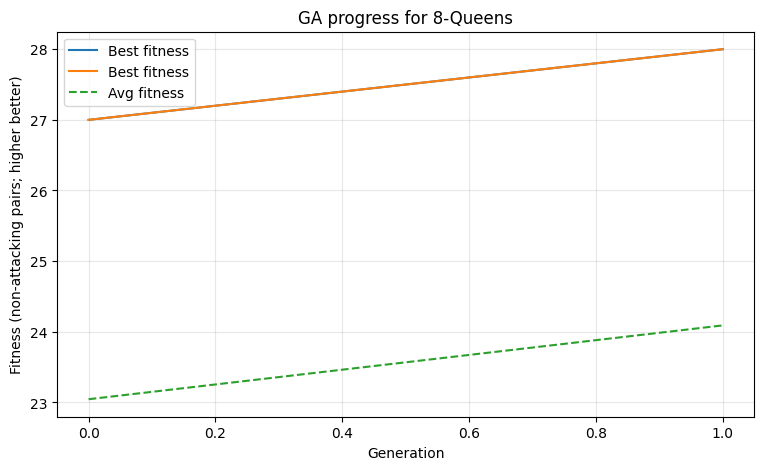

Conflicts of best: 0
Solution (board as column->row): [1, 6, 4, 7, 0, 3, 5, 2]


In [10]:
# Code and description go here
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Utility: conflicts & fitness (permutation representation)
# ------------------------
def conflicts_perm(perm):
    """
    perm: list of length n, perm[col] = row (permutation of 0..n-1)
    returns number of attacking pairs on diagonals.
    """
    n = len(perm)
    conf = 0
    for i in range(n):
        for j in range(i+1, n):
            if abs(perm[i] - perm[j]) == abs(i - j):
                conf += 1
    return conf

def fitness_perm(perm):
    """Fitness: number of non-attacking pairs (higher is better)."""
    n = len(perm)
    total_pairs = n * (n - 1) // 2
    return total_pairs - conflicts_perm(perm)

# ------------------------
# Genetic operators
# ------------------------
def tournament_selection(pop, fitnesses, k=3):
    """Return one individual chosen by tournament of size k."""
    selected_idx = random.sample(range(len(pop)), k)
    best = selected_idx[0]
    for idx in selected_idx[1:]:
        if fitnesses[idx] > fitnesses[best]:
            best = idx
    return pop[best][:]  # return copy

def order_crossover(parent1, parent2):
    """
    Order Crossover (OX) for permutations.
    Returns two children.
    """
    n = len(parent1)
    a, b = sorted(random.sample(range(n), 2))
    # child templates
    child1 = [-1]*n
    child2 = [-1]*n
    # copy slice
    child1[a:b+1] = parent1[a:b+1]
    child2[a:b+1] = parent2[a:b+1]

    def fill_child(child, donor):
        n = len(child)
        pos = (b+1) % n
        donor_pos = (b+1) % n
        while -1 in child:
            val = donor[donor_pos]
            if val not in child:
                child[pos] = val
                pos = (pos + 1) % n
            donor_pos = (donor_pos + 1) % n
        return child

    child1 = fill_child(child1, parent2)
    child2 = fill_child(child2, parent1)
    return child1, child2

def swap_mutation(perm, mutation_rate=0.1):
    """Swap mutation: with probability mutation_rate, swap two positions."""
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(perm)), 2)
        perm[i], perm[j] = perm[j], perm[i]
    return perm

# ------------------------
# GA main loop
# ------------------------
def genetic_algorithm_nqueens(n,
                             pop_size=100,
                             generations=500,
                             crossover_rate=0.9,
                             mutation_rate=0.2,
                             tournament_k=3,
                             elitism=2,
                             stop_if_found=True,
                             verbose=False):
    """
    Returns: best_perm, best_conflicts, history dict (best_fitness, avg_fitness)
    """
    # initialize population: permutations
    pop = [random.sample(range(n), n) for _ in range(pop_size)]
    fitnesses = [fitness_perm(ind) for ind in pop]
    best_idx = int(np.argmax(fitnesses))
    best = pop[best_idx][:]
    best_fit = fitnesses[best_idx]
    history_best = [best_fit]
    history_avg = [np.mean(fitnesses)]

    total_pairs = n*(n-1)//2

    for gen in range(1, generations+1):
        new_pop = []
        # Elitism: keep top 'elitism' individuals
        sorted_indices = sorted(range(pop_size), key=lambda i: fitnesses[i], reverse=True)
        for i in range(elitism):
            new_pop.append(pop[sorted_indices[i]][:])

        # generate offspring
        while len(new_pop) < pop_size:
            # selection
            parent1 = tournament_selection(pop, fitnesses, k=tournament_k)
            parent2 = tournament_selection(pop, fitnesses, k=tournament_k)
            # crossover
            if random.random() < crossover_rate:
                child1, child2 = order_crossover(parent1, parent2)
            else:
                child1, child2 = parent1[:], parent2[:]
            # mutation
            child1 = swap_mutation(child1, mutation_rate)
            child2 = swap_mutation(child2, mutation_rate)
            new_pop.append(child1)
            if len(new_pop) < pop_size:
                new_pop.append(child2)

        pop = new_pop
        fitnesses = [fitness_perm(ind) for ind in pop]

        # update best
        cur_best_idx = int(np.argmax(fitnesses))
        cur_best_fit = fitnesses[cur_best_idx]
        if cur_best_fit > best_fit:
            best_fit = cur_best_fit
            best = pop[cur_best_idx][:]
        history_best.append(best_fit)
        history_avg.append(np.mean(fitnesses))

        # stop if perfect solution found (conflicts = 0)
        if stop_if_found and best_fit == total_pairs:
            if verbose:
                print(f"Found perfect solution at generation {gen}")
            break

        if verbose and gen % 50 == 0:
            print(f"Gen {gen}: best_fit={best_fit}, avg={history_avg[-1]:.2f}")

    best_conflicts = total_pairs - best_fit
    history = {"best_fitness": history_best, "avg_fitness": history_avg}
    return best, best_conflicts, history

# ------------------------
# Demo + Visualization
# ------------------------
if __name__ == "__main__" or True:
    # demo parameters
    n = 8
    pop_size = 200
    generations = 500
    crossover_rate = 0.9
    mutation_rate = 0.2
    tournament_k = 3
    elitism = 4

    t0 = time.time()
    best, best_conflicts, history = genetic_algorithm_nqueens(
        n,
        pop_size=pop_size,
        generations=generations,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        tournament_k=tournament_k,
        elitism=elitism,
        stop_if_found=True,
        verbose=True
    )
    t1 = time.time()

    print(f"\nGA finished in {t1-t0:.3f}s")
    print(f"n = {n} | best conflicts = {best_conflicts} | best perm = {best}")

    # plot fitness over generations
    best_f = history["best_fitness"]
    avg_f = history["avg_fitness"]
    gens = list(range(len(best_f)))

    plt.figure(figsize=(9,5))
    plt.plot(gens, [ (n*(n-1)//2 - ( (n*(n-1)//2) - bf )) for bf in best_f ], label="Best fitness") # best_f already fitness
    # actually plot directly best_f and avg_f for clarity:
    plt.plot(gens, best_f, label="Best fitness")
    plt.plot(gens, avg_f, label="Avg fitness", linestyle="--")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (non-attacking pairs; higher better)")
    plt.title(f"GA progress for {n}-Queens")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # If solution found show conflicts count (should be 0)
    print("Conflicts of best:", best_conflicts)
    if best_conflicts == 0:
        print("Solution (board as column->row):", best)


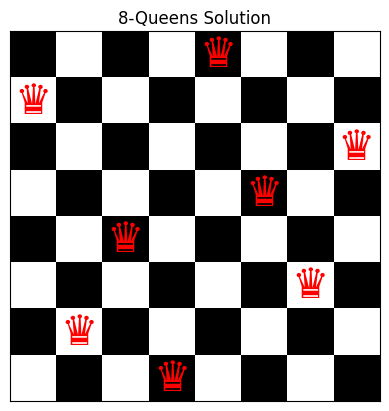

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_n_queens(solution):
    n = len(solution)
    board = np.zeros((n, n))
    
    # Đánh dấu các vị trí của quân hậu
    for col, row in enumerate(solution):
        board[row, col] = 1  # 1 biểu thị có quân hậu

    # Vẽ bảng cờ
    fig, ax = plt.subplots()
    ax.matshow(np.indices((n, n)).sum(axis=0) % 2, cmap='gray')  # bàn cờ đen-trắng

    # Vẽ quân hậu
    for col, row in enumerate(solution):
        ax.text(col, row, '♛', ha='center', va='center', fontsize=30, color='red')

    ax.set_xticks([])
    ax.set_yticks([])
    plt.title(f"{n}-Queens Solution")
    plt.show()

# Ví dụ dùng với solution của bạn
solution = [1, 6, 4, 7, 0, 3, 5, 2]
plot_n_queens(solution)
